In [1]:
import sys

import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy
import logging

import common
import util
importlib.reload(common)
importlib.reload(util)

from common import create_engine
from common import display_all
from common import figsize
from common import save_df, load_df
from common import save_session, load_session

from util import show_importances
from util import split_X_y_all, split_X_y, split_data
from util import empty_features, column_feature, str_contains

from pbar import Pbar

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters() # converters e.g. for datetime in plots
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
RANDOM_STATE = 123
np_random = np.random.RandomState(RANDOM_STATE)

In [3]:
df = load_df('final_data.pickle')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15458 entries, 431065 to 812426
Data columns (total 68 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   title                    15458 non-null  object        
 1   perex                    15458 non-null  object        
 2   body                     15458 non-null  object        
 3   raw_body                 15458 non-null  object        
 4   published_at             15458 non-null  datetime64[ns]
 5   extracted_at             15458 non-null  datetime64[ns]
 6   category                 10307 non-null  object        
 7   other_info               15458 non-null  object        
 8   image_count              15458 non-null  int64         
 9   video_count              15458 non-null  int64         
 10  author_name              15458 non-null  object        
 11  source_id                15458 non-null  int64         
 12  source_name              1

In [5]:
print('rozsah datumov publikovania clankov')
df.published_at.describe()

rozsah datumov publikovania clankov


count                   15458
unique                  10670
top       2019-11-07 00:00:00
freq                       51
first     2019-10-21 00:00:00
last      2020-04-07 09:00:00
Name: published_at, dtype: object

In [6]:
print(f'pocet zdrojov {len(df.source_name.unique())}')

pocet zdrojov 56


pocetnost clankov podla doveryhodnosti zdroja
1    9068
0    6390
Name: source_is_reliable, dtype: int64


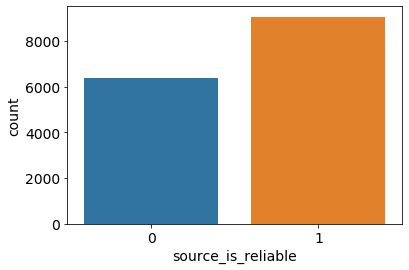

In [18]:
print('pocetnost clankov podla doveryhodnosti zdroja')
print(df.source_is_reliable.value_counts())
sns.countplot(data=df,
             x='source_is_reliable')

In [19]:
df.source_name.unique().size

56

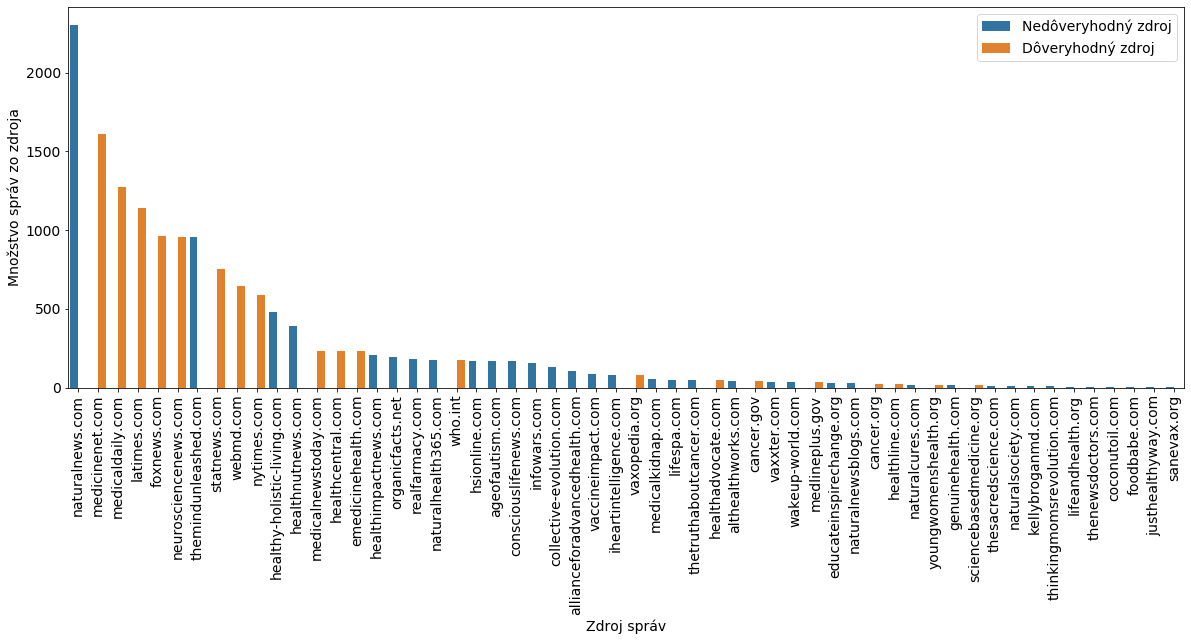

In [8]:
plt.figure(figsize=(20,7))
plt.rcParams.update({'font.size': 14})

ax = sns.countplot(data=df,
              x='source_name', 
              hue='source_is_reliable', 
              order=df.source_name.value_counts().index)

ax.set(xlabel='Zdroj správ', ylabel='Množstvo správ zo zdroja')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(['Nedôveryhodný zdroj', 'Dôveryhodný zdroj'], loc="upper right")
ax.get_figure().savefig('export/zdroje-doveryhodnost.png', bbox_inches = "tight")

In [9]:
df.groupby('source_name')['source_is_reliable'].unique().apply(lambda x: x[0])

source_name
ageofautism.com                  0
allianceforadvancedhealth.com    0
althealthworks.com               0
cancer.gov                       1
cancer.org                       1
coconutoil.com                   0
collective-evolution.com         0
consciouslifenews.com            0
educateinspirechange.org         0
emedicinehealth.com              1
foodbabe.com                     0
foxnews.com                      1
genuinehealth.com                0
healthadvocate.com               1
healthcentral.com                1
healthimpactnews.com             0
healthline.com                   1
healthnutnews.com                0
healthy-holistic-living.com      0
hsionline.com                    0
iheartintelligence.com           0
infowars.com                     0
justhealthyway.com               0
kellybroganmd.com                0
latimes.com                      1
lifeandhealth.org                0
lifespa.com                      0
medicaldaily.com                 1
medicalk

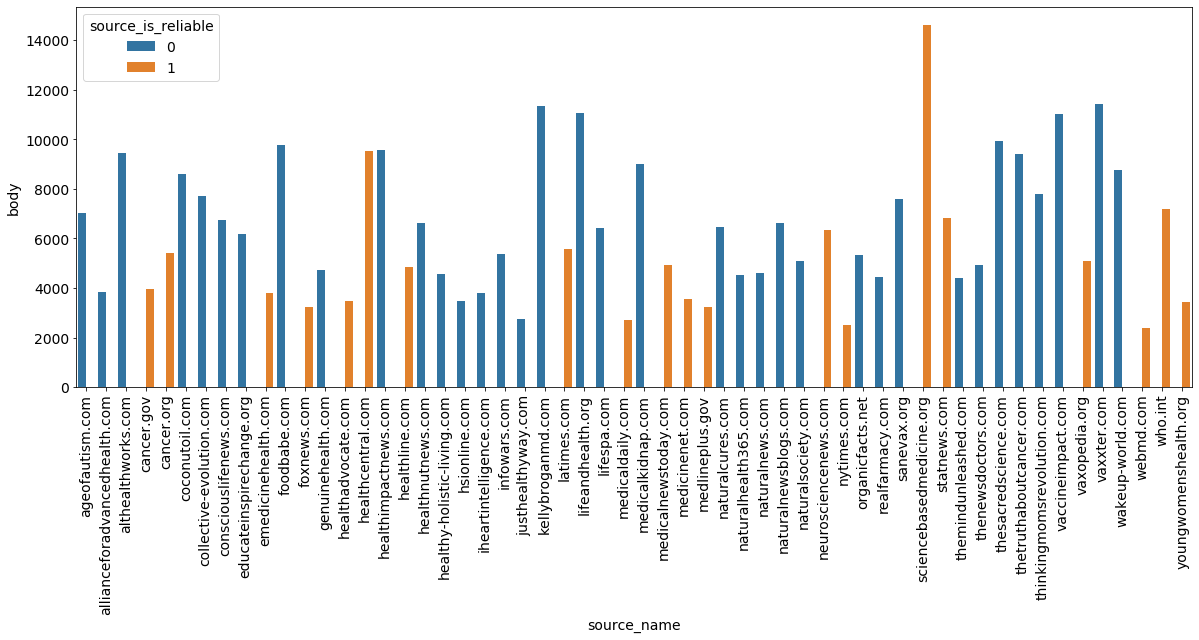

In [10]:
x = pd.DataFrame([
    df.groupby('source_name')['body'].apply(lambda x: np.mean(x.str.len()))
]).transpose()
x['source_is_reliable'] = df.groupby('source_name')['source_is_reliable'].unique().apply(lambda x: x[0])
plt.figure(figsize=(20,7))
x = x.reset_index()

ax = sns.barplot(data=x, x='source_name', y='body', hue='source_is_reliable')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax

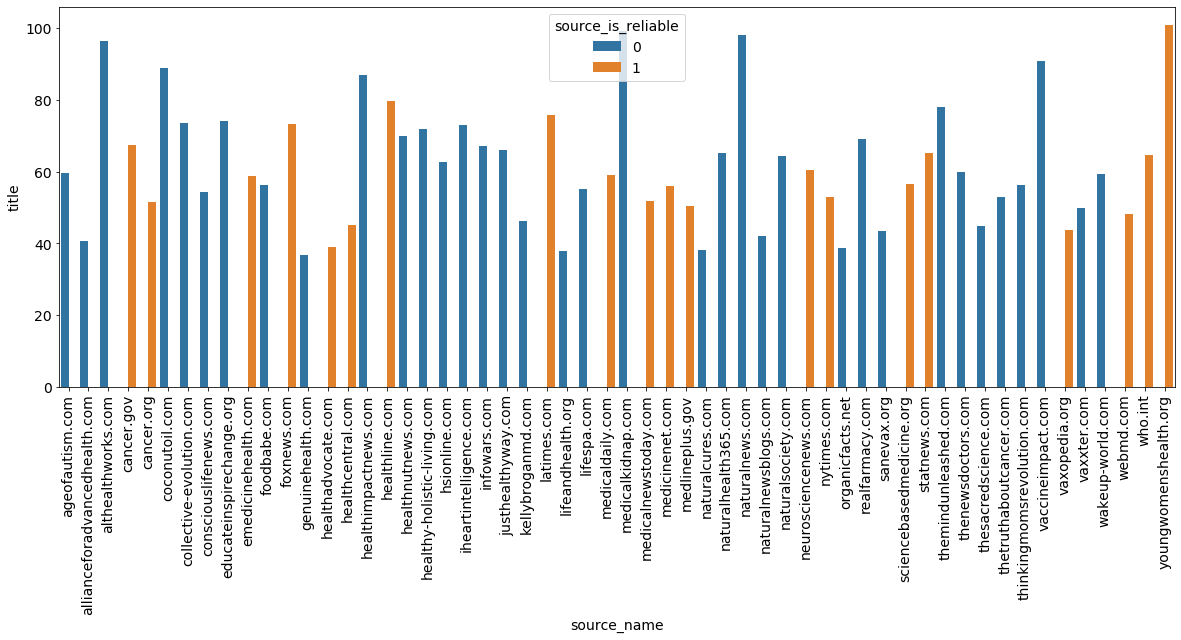

In [11]:
x = pd.DataFrame([
    df.groupby('source_name')['title'].apply(lambda x: np.mean(x.str.len()))
]).transpose()
x['source_is_reliable'] = df.groupby('source_name')['source_is_reliable'].unique().apply(lambda x: x[0])
plt.figure(figsize=(20,7))
x = x.reset_index()

ax = sns.barplot(data=x, x='source_name', y='title', hue='source_is_reliable')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax

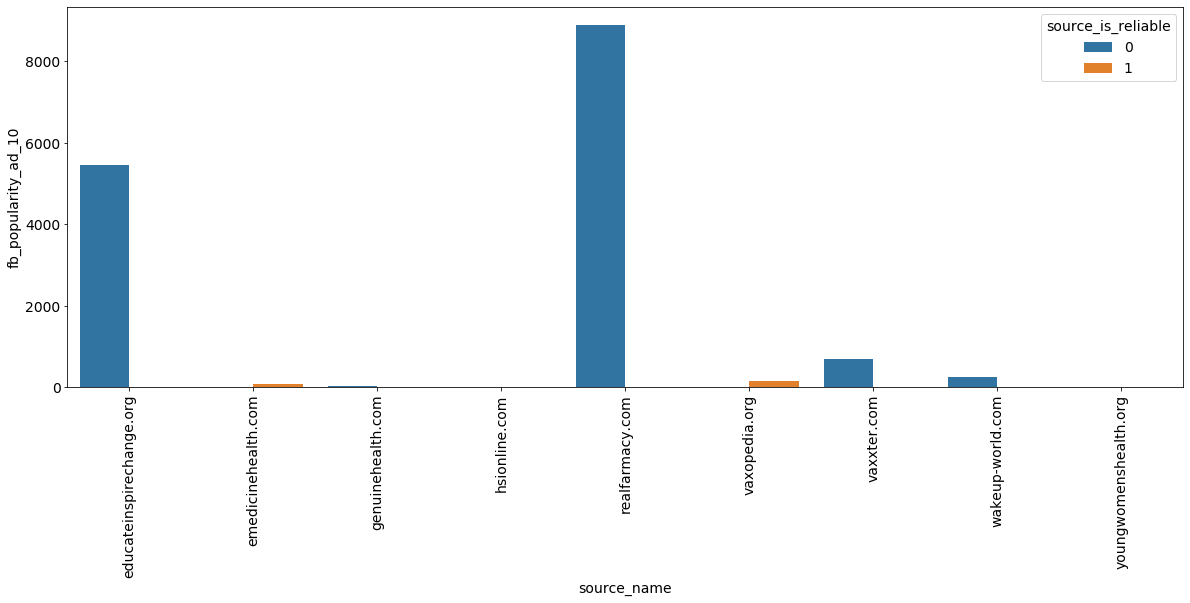

In [12]:
q = df[df.source_name.isin([
    'youngwomenshealth.org',
    'vaxopedia.org',
    'emedicinehealth.com',
    
    'hsionline.com',
    'wakeup-world.com',
    'genuinehealth.com',
    'realfarmacy.com',
    'educateinspirechange.org',
    'vaxxter.com'
])].copy()

x = pd.DataFrame([
    q.groupby('source_name')['fb_popularity_ad_10'].apply(lambda x: np.mean(x))
]).transpose()
x['source_is_reliable'] = q.groupby('source_name')['source_is_reliable'].unique().apply(lambda x: x[0])
plt.figure(figsize=(20,7))
x = x.reset_index()

ax = sns.barplot(data=x, x='source_name', y='fb_popularity_ad_10', hue='source_is_reliable')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax